# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from comp411.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from comp411.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from comp411.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.42 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

loss_types = ["SVM"]
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        for loss_type in loss_types:
            
            classifier = LinearSVM()
            
            
            classifier.train(X = X_train_feats, y = y_train,learning_rate=learning_rate,reg=regularization_strength,num_iters=1500)
            validation_y_pred = classifier.predict(X_val_feats)
            validation_num_correct = np.sum(validation_y_pred == y_val)
            validation_accuracy = float(validation_num_correct) / len(validation_y_pred)

            y_train_pred = classifier.predict(X_train_feats)
            training_num_correct = np.sum(y_train_pred == y_train)
            training_accuracy = float(training_num_correct) / len(y_train_pred)

            results[(learning_rate,regularization_strength)] = (training_accuracy,validation_accuracy)

            if best_val < validation_accuracy:
                best_val = validation_accuracy
                best_svm = classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

170.0314706218942
169.99299296885206
169.976738888762
169.92677487356204
169.88962689436056
169.87243667623892
169.8425289621892
169.79252085405557
169.77278023173415
169.72493889285744
169.70532937852994
169.68407617654668
169.63730426608376
169.60058505934438
169.58399649719672
169.5493607661697
169.5058376312451
169.4737311765875
169.4503704927405
169.39490928345657
169.3698590939296
169.35661776584618
169.30893643210842
169.28192108619882
169.23639254407757
169.20990087573733
169.17855369123225
169.13934836371993
169.11610315870425
169.10787271869813
169.0757503638788
169.00044982401533
168.9937832890651
168.9742195754636
168.92925496697006
168.89771228520794
168.87490454217908
168.84024679276135
168.81227820254884
168.77109454796974
168.73452048031334
168.71161186596868
168.67192009627757
168.64812791268147
168.6028373587606
168.5910878304803
168.53599008098297
168.52111238413767
168.47842305172574
168.45660937663828
168.4399638950312
168.41115035810745
168.36122175546987
168.3291

146.2921406401771
146.28172996756885
146.24635541601316
146.2150978729985
146.20446444319919
146.16984394440854
146.1407795832522
146.11671187922138
146.0644781391315
146.07074321988972
146.02111149059672
146.01251468701705
145.98069265367866
145.94271220936284
145.92105898522513
145.8769023019716
145.85374963906546
145.83467643896392
145.8000747290154
145.78442966682871
145.745703491018
145.72280251458943
145.706471477538
145.68179200182067
145.64472675664513
145.6097074289608
145.59335099058822
145.56733769412307
145.54159712021124
145.5015881620158
145.47929323176052
145.44484345943812
145.42063345246126
145.39684689379266
145.3827325246106
145.33797729533373
145.31863454016215
145.2781974582113
145.26636048067803
145.25362868986758
145.1947883341409
145.1812741268773
145.13035449724643
145.12103292561184
145.09167080785747
145.0770582505566
145.0373383008797
145.01809870951297
144.98969148993157
144.9560814332171
144.93938423203926
144.90367182239265
144.8843755282179
144.836822980

1264.1680947757407
1261.6540794076195
1259.1486613069171
1256.6515440393794
1254.1490570760768
1251.6672404707485
1249.174388546483
1246.7097869019092
1244.240601336138
1241.7631602412728
1239.3050576265812
1236.837640315567
1234.3952917920546
1231.9281977413295
1229.503056160921
1227.0430076371695
1224.6082212804622
1222.174857656712
1219.755523967673
1217.338620046575
1214.9215754836894
1212.5045084964624
1210.095418346249
1207.7123573010006
1205.3187739729756
1202.9235951766527
1200.5244308573301
1198.133709907512
1195.7679744754853
1193.4056123496937
1191.0354400498409
1188.668905562291
1186.2972963727257
1183.9609368370943
1181.6066276531246
1179.2629276846233
1176.9193379190262
1174.5861889202392
1172.2685250325176
1169.9354736806595
1167.6244529649737
1165.308910062509
1162.9885897439674
1160.6808442257402
1158.3774466786053
1156.0745872237007
1153.770017639453
1151.4997208307611
1149.2209023575736
1146.9306995443333
1144.657601371825
1142.3937296823442
1140.1294189555178
1137.8

248.89477859391303
248.41651891157676
247.93242990601743
247.44954637376554
246.98335117677158
246.50218929740308
246.02864530978516
245.54971625163006
245.08487825419587
244.60636386613902
244.13541208041394
243.66930889523488
243.19878021328617
242.72666585951742
242.26387533376788
241.79641448785333
241.3285575558244
240.86177100316368
240.40345419151427
239.9370117382637
239.48357354697754
239.01896693156647
238.5533331712608
238.10324072394886
237.6439036278366
237.17896031808837
236.72779665239213
236.2783235629486
235.8195139543622
235.36558519647528
234.91674774963454
234.46684074191
234.0099930196774
233.56143371099583
233.11490971816733
232.66874208212224
232.21640029291325
231.77305866155376
231.3227862493118
230.87145324977413
230.43129825167858
229.99365037448985
229.5571736548963
229.11478569719245
228.67505838038898
228.23288184663733
227.79789830521239
227.35971205082234
226.92313259353273
226.48912623650273
226.0428087459717
225.61513770417616
225.18753941395457
224.75

227.4782555582334
223.13172299910136
218.86921630500836
214.69315498742998
210.60226128317862
206.58958241183535
202.65600232269463
198.8030307515717
195.02520976543036
191.32538572271335
187.69697930259744
184.13907613265542
180.65464414460914
177.23692824244367
173.8901538907059
170.6084001797325
167.39314756233455
164.240299855651
161.15105018055792
158.1229612876972
155.15563371775238
152.2467258504154
149.39677028779911
146.60342868837233
143.86529386747378
141.18039533074975
138.54966751982317
135.97314264687404
133.44693755985577
130.9692896162811
128.54198065202732
126.16305525818278
123.83066059072013
121.54711542642335
119.3070043417774
117.11187006126156
114.95937908794683
112.85225764799083
110.78499695556
108.76051344645833
106.7742046181153
104.82803885013537
102.9223646137225
101.05231924229454
99.22099774764663
97.42532940072843
95.664989748019
93.94017844811269
92.25036553055193
90.59429257453428
88.9696590571429
87.37948127732137
85.81874116552126
84.291519443418
82.7

9.000009415166767
9.000009757878031
9.000009368208389
9.000009760600776
9.000009931094226
9.000008621197189
9.000008336680377
9.000008251562075
9.000008941124037
9.000008561693493
9.000008000878747
9.00000856820913
9.000007362479598
9.000007951159692
9.000007110538876
9.000007271584147
9.000007374163681
9.00000661694162
9.000007273843993
9.000006583012693
9.000006264938698
9.000006435969182
9.000005940493233
9.000005937119104
9.000006429458253
9.000006546659746
9.00000679900861
9.00000608916312
9.000005824242724
9.000006466935407
9.000005085144833
9.000006048097982
9.000005116206015
9.000004951298846
9.000004596496957
9.000005051569408
9.000005370363269
9.000005710544205
9.000004671199427
9.000003530046012
9.00000378578973
9.000004204892575
9.000003487564703
9.000004763503442
9.000004677749637
9.000004005757486
9.000003411333491
9.000004351932654
9.000004367808085
9.000003516498316
9.000003898734823
9.000003797441396
9.000003138899846
9.000003893881754
9.000003600860758
9.0000033305807

82.86255100856465
82.71941778646186
82.5715059846805
82.42066280745927
82.27990900749651
82.12097946642646
81.97835322936338
81.84757307257102
81.70249773493062
81.53694156127017
81.40508795576869
81.25215200945392
81.10999473236075
80.96806493150362
80.82394668878585
80.68859245635856
80.5388460521324
80.39067935268552
80.25476061141293
80.10458424295635
79.96486769499134
79.82807728132587
79.68291193116255
79.5365495923163
79.39866429213278
79.26430443363661
79.11586546706033
78.98154383568698
78.84755463533165
78.7068533738442
78.56324082627505
78.42288136949493
78.28409666889797
78.1444932170003
78.00910775172186
77.86620891923211
77.73450274233815
77.58804454555842
77.45473197873734
77.32570600478624
77.18598783498454
77.05028085282224
76.90487719257497
76.7818406027517
76.63411910236174
76.49939456288908
76.36260989538523
76.22858330276307
76.10303483624133
75.95995419258
75.83045605303242
75.71067322666428
75.56562995491349
75.43742440498123
75.2959605298555
75.17160902386976
75

23.32487219353346
23.284601661888793
23.258577470543372
23.230334858969584
23.2017745209235
23.17833771765527
23.143479831098425
23.117600393383263
23.08857647624515
23.063896590382114
23.03212547037088
23.00654775725299
22.978738643116987
22.948640479490823
22.91876338311325
22.895406870382743
22.864962936365476
22.8395711690103
22.809056550326925
22.777084105113374
22.755835212261914
22.727584505431825
22.69833297228042
22.67068019898137
22.647160077760013
22.617132683676225
22.59345752330887
22.56328879842612
22.539060683026264
22.508970028840864
22.480269286718844
22.45478341786015
22.43318550397531
22.400702838481706
22.379752155557362
22.344643576578232
22.31940563071426
22.29707219750378
22.26472219913707
22.23974237039449
22.21777469630717
22.192249838763175
22.165279661318127
22.135017968422716
22.113764562024876
22.086663831061983
22.05602217181525
22.03316219973733
22.00457575190174
21.979094145330397
21.953230834079818
21.92668885381864
21.906051741515967
21.878962749319445

9.05869053703098
9.05754320987604
9.056343417189218
9.05525418869282
9.054181922878678
9.053077000138462
9.05198159464178
9.050976140570178
9.049889222697384
9.04892637270278
9.047970298680637
9.04711674455165
9.04611569562552
9.045193182611753
9.044335468699058
9.043372608342942
9.042529434496188
9.04167618382675
9.040855719117703
9.040003131115895
9.039229532415058
9.038402840469859
9.037709295867975
9.0369421079519
9.036215873291686
9.035537696357142
9.034765033261944
9.034092477045036
9.03338531788984
9.032708059572377
9.032072351351136
9.031449195553574
9.030797907401775
9.03027012762481
9.029595974303493
9.029048941481747
9.028403632879677
9.027847802578743
9.027399107520576
9.026726323353707
9.026216710618774
9.025720937941417
9.025141368253424
9.024694376754564
9.024174110483656
9.023740400221353
9.023226097022695
9.022829929518737
9.022332827962503
9.021940043965651
9.02144436093337
9.021037861760838
9.020570156967123
9.020239543767447
9.019897794582961
9.019399201673517
9.019

9.00000556731599
9.000000782971446
9.000001000322214
9.000003402474304
8.999995082474099
8.99999844245796
8.99999896518174
8.999992661710026
8.999992414709691
8.999999796618267
9.000000980584343
9.000012688489436
9.000005621397666
9.000001582610176
9.000002406751701
8.99999783920567
8.99999414611004
9.000007145589967
8.999997216057748
9.000001924673159
9.000004530315334
8.999996332900002
9.00000130385798
9.000003929526953
9.000000080267215
8.999997380788054
9.000001260113873
8.999995996720283
8.999998520447638
8.999995645198624
8.999999912297568
9.000002526809237
8.999998661207337
9.000001809255437
9.000001062246737
8.999998867301962
8.999997881720931
9.000001232949165
8.999995233664144
9.000000459839455
9.000001226306784
9.000002728113907
8.999999237992126
8.999996315979203
8.999999915432692
9.000001512566735
8.999989183596002
9.000003364083755
8.99999564019871
8.999998361414905
8.999996439187132
9.00000439922263
9.000006816274219
9.00000234494838
8.999995382202586
9.00000327086938
8.

9.000000334752858
9.000000194120004
9.000000355425422
8.99999961584685
9.000000633840264
9.000000285753812
8.999998952876258
9.000000432153104
9.000000036681632
9.000001894115227
9.00000070985593
9.000000482666811
9.000000943998693
9.000000454284777
9.000000340189384
9.000000666856982
9.000000489442183
9.000000146620309
8.999999435261776
8.999999779816253
8.9999996660243
8.999999635638261
9.000001086653455
9.000000274956255
9.00000091365965
9.000000053369876
9.000001183068177
9.000000763420868
8.999999522792951
9.00000019458947
9.00000048297315
9.000000952365145
9.000001442788644
9.000000355295938
9.000000213028413
9.000001475338504
9.000000608089676
9.000000008617269
9.00000061941401
9.000000476899972
8.99999977888404
9.000000457782038
9.000001009952637
9.000000308583816
9.000000747344313
8.999999796816343
9.000000255176925
9.000000022452841
9.000001121678483
8.999999638894142
8.99999997127937
9.000000122809647
8.99999974438936
9.000000636941165
9.0000007566596
9.000000216193198
8.999

9.000000639176621
9.000001055848697
8.999999357981798
9.000000558006871
9.000000715622368
9.00000049966047
9.000000163780175
9.000001004944355
9.000000318597586
9.000000176889108
9.00000007509357
9.000000593575223
164.70178006644502
161.6016966403883
158.54895705774857
155.59007247448758
152.66779132971476
149.81021743644365
147.01477646484065
144.27444069392214
141.5714119829312
138.9368229106035
136.35072462547234
133.80281102324955
131.3281580901353
128.899400775594
126.50323405303077
124.17551493709522
121.87121812372021
119.63361704555464
117.41911250007814
115.27699794151002
113.17323063490026
111.08198031566774
109.06195964764325
107.06788671446874
105.12350714709318
103.20091797308233
101.32460163863267
99.48465089186809
97.68384951449222
95.92170257632094
94.19812089188783
92.49616038003403
90.8356918392621
89.21163929002
87.61452921363357
86.04631396577014
84.50809199042394
83.01652151670908
81.53730829494185
80.0931917076251
78.68566277084734
77.29996834263413
75.93229792258

8.999981764848553
8.999975929779302
9.00000566490068
9.000029185108325
9.00000515532216
9.000012750389415
9.000007892039514
9.000033260897444
9.000124701314679
9.000106063898766
9.000085829212244
9.000116032823477
9.000037649211938
9.000055870812606
8.999953437023056
8.999961052430171
8.999850989384672
9.000049197874127
9.000054571961265
9.000008174954663
8.99995730652396
9.000035267503936
9.00006049532604
9.000013797787142
9.00005604712983
8.999993230962971
9.000064064779163
9.000050721191258
9.0000019526991
8.999932035195679
9.00006943856935
9.000049460810374
8.999965643353676
8.999968390693036
8.999971750329827
8.999967222278372
9.000010301855577
9.000022159177545
9.00000988092249
9.000067531436832
9.000010143317805
9.000012259471985
9.000079626813141
8.999956325370892
8.99997425117095
8.999906920412483
8.999965000740008
9.000067239212676
8.999979339161671
8.999985840178223
9.00001445189541
8.999929982281222
9.000010044434731
8.999986292808652
8.999965050781631
8.99993415439638
9.00

9.000001221709528
9.000007779134148
8.999993923244094
9.000010497612498
9.000001331181412
9.000003582228068
9.000009911720278
9.000003840353623
9.000005029809747
9.000004438477582
9.000006102365635
9.000003075430051
8.999996579015196
9.000006526196069
9.000010435103503
9.000010966564128
9.000005228489865
8.999998715330348
9.000001274987177
9.00000017253861
8.999999804168725
9.000004990687321
9.000001719463748
8.999999556833135
9.00001296203988
9.000002694310018
9.000004861839358
8.99999545899017
9.000001016339684
9.000009842022221
9.000007149635909
9.0000019099304
9.000004639099807
8.99999938383664
8.99999944214021
8.999999021465555
9.000006265919557
9.000001710618406
9.000006597715378
8.999999818282518
9.000009095920234
9.000003685312196
9.000004530810935
8.999996632552064
9.00000273933004
9.000005328773607
9.000001128408359
8.999997678381547
9.000003856156134
9.000000673676343
9.000011572399556
9.000002693891336
9.00000275062864
9.00000547814708
9.000009167527526
8.999998383421715
9.

9.000009192656417
9.000000120571482
9.00000780333767
8.999997004707945
9.000005076110142
8.999997989732753
9.000000248232206
8.999996412675786
9.000001085507108
9.000010312600093
9.000001951402778
9.00000872804902
9.000007278103158
9.000011546234125
9.000000465761877
8.99999817564683
9.000004726520187
9.000007677047268
8.999997706010086
9.000002323424738
8.99999599556838
9.000006597849298
9.00000011626058
8.999998330136988
9.00000398305621
9.000008348868057
8.999997659435895
9.000007592625948
9.000001776549801
8.999995452525377
9.000005542197222
9.000003324307125
9.00000407007476
9.000010448495843
9.000006353093468
8.999999525616762
9.000004651041072
9.000012177703596
9.00000004892548
8.999996085804593
9.000008726594682
9.000013527906663
8.999999690756114
8.999999063329183
9.000003800968274
9.000014609838642
9.00000056827996
9.000000521619484
9.000005630304486
9.000005371536323
9.000007916838229
9.000004144559249
9.000001598297471
8.999998340568652
9.00000174130807
9.00000187826254
8.9

9.000008301645186
9.000006979716487
9.00000635583283
9.00000677275388
9.000007515921302
9.000006088859768
9.000007593075619
9.000007896013544
9.000006800745203
9.000007744211908
9.000007771443489
9.000005698150648
9.000007137006733
9.000007832924112
9.000005883828253
9.000007773592397
9.000007000954588
9.000006502648496
9.000009168089479
9.000005446464158
9.000007044357508
9.000006080935904
9.000007145074495
9.00000687682433
9.000004627436692
9.000007412962765
9.00000671285017
9.000007045299311
9.000007535217245
9.000008117925258
9.000005849778457
9.000007190125414
9.000007714980818
9.000006887468896
9.00000618927653
9.000007384242595
9.000006812972329
9.00000832552285
9.0000071484275
9.000007110196092
9.000007903119206
9.00000741149573
9.00000707920668
9.00000841742651
9.00000581255187
9.000007604515766
9.00000606208573
9.000006132916774
9.00000581642359
9.000004449014254
9.000009766456333
9.000006980526704
9.000006912285825
9.00000710054709
9.000008141879048
9.000006597229888
9.00000

9.000005717312344
9.00000755268763
9.000006950404916
9.000006320050545
9.000005700715223
9.000008492331967
9.000006750610522
9.00000577389285
9.00000578056468
9.000008441887662
9.000005877142033
9.000007504842616
9.0000056310923
9.00000809279838
9.000008097019164
9.000006781519163
9.000006302077567
9.000007502175343
9.000006866545073
9.000006941149413
9.00000658823564
9.000007323330534
9.000006302905586
9.0000072632011
9.000005879562675
9.000006362547444
9.0000080410168
9.00000608072934
9.000007113026678
9.000005607608955
9.000007163026208
9.000007541476524
9.000007404367247
9.000006660970042
9.000008979901722
9.000006028788595
9.000007985186564
9.000005707411304
9.000007069587115
9.000007167716237
9.00000900228408
9.000006305576242
9.000005911522903
9.000007335070615
9.000007765654304
9.000006349747041
9.000006870962041
9.00000580612428
9.000007438823227
9.000006264999175
9.000007551820646
9.000007840457759
9.000004744920052
9.000007540551914
9.000005920631159
9.00000666694204
9.00000

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


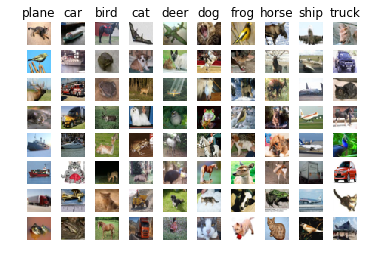

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ It makes sense most of the picture are misclassified, I can't find any correctly classified picture

## Neural Network on image features
Earlier in this assigment we saw that training a four-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 58% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from comp411.classifiers.neural_net import FourLayerNet



input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = FourLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a three-layer neural network on image features. You may want to  #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


#for i in [100, 200, 300,400,500,600,700,800,900]:
#for i in [100, 100,100,100,100]:
#for i in [1e-1, 1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9, 1e-10]:
#input_size = 32 * 32 * 3
#hidden_size = i
#num_classes = 10
#best_net = FourLayerNet(input_size, hidden_size, num_classes)
#2e-1,5e-7
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size= 200,
            learning_rate= 8e-1, learning_rate_decay=0.99,
            reg= 5e-5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)
best_net=net


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 2000: loss 2.305418
iteration 100 / 2000: loss 2.036714
iteration 200 / 2000: loss 1.533988
iteration 300 / 2000: loss 1.419426
iteration 400 / 2000: loss 1.381056
iteration 500 / 2000: loss 1.170309
iteration 600 / 2000: loss 1.420504
iteration 700 / 2000: loss 1.219058
iteration 800 / 2000: loss 1.288855
iteration 900 / 2000: loss 1.175960
iteration 1000 / 2000: loss 0.975945
iteration 1100 / 2000: loss 1.115835
iteration 1200 / 2000: loss 0.994112
iteration 1300 / 2000: loss 0.960325
iteration 1400 / 2000: loss 0.940088
iteration 1500 / 2000: loss 0.937927
iteration 1600 / 2000: loss 0.954921
iteration 1700 / 2000: loss 0.825434
iteration 1800 / 2000: loss 0.889515
iteration 1900 / 2000: loss 0.732743
Validation accuracy:  0.566


In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.574
